# Comprobación de funcionamiento modelo ML prdicción_precio_original_1

### La idea es importar el modelo para predicción del precio original y comprobar si se exportó correctamente. Para ello se busca replicar lo mismo, pero importando el modelo ajustado en lugar de crear y ajustar uno en este mismo notebook

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
import joblib

fecha_scraping = datetime.now().strftime("%Y-%m-%d")

In [2]:
from scipy.stats import f_oneway, kruskal #importamos estas librerías para su uso en los test de kruskal wallis y anova de una vía.

from sklearn.model_selection import train_test_split #Para separar en conjunto de entrenamiento y de prueba.
from sklearn.linear_model import LinearRegression #importamos la función para la creación de modelos de regresión lineal de sklearn.
from sklearn.metrics import mean_squared_error, r2_score #importamos las funciones para el cálculo de métricas de bondad de ajuste R^2 y MSE.
import statsmodels.api as sm #Importamos librería statsmodels que entrega los modelos de regresión. Servirá para utilizar modelos de regresión lineal.
from statsmodels.miscmodels.ordinal_model import OrderedModel #para utilizar el modelo multinomial ordinal.
from imblearn.over_sampling import SMOTE #para realizar remuestreo con SMOTE y balanceo de clases.

#Importamos métricas para medir la eficacia del modelo de clasificación multinomial ordinal.
from sklearn.metrics import accuracy_score
from sklearn.metrics import accuracy_score, classification_report, cohen_kappa_score, f1_score
from sklearn.metrics import confusion_matrix

import joblib

def estandarizar(df):
    df_scaled = df.copy()
    num_cols = df.select_dtypes(include="number").columns
    
    df_scaled[num_cols] = (df[num_cols] - df[num_cols].mean()) / df[num_cols].std()
    
    return df_scaled

In [ ]:
df = pd.read_csv(f"../data/processed/ofertas_2025_08_24.csv", sep=";", decimal=",", encoding="utf-8")


In [4]:
modelo_cargado = joblib.load("../models/prediccion_precio_original_1.joblib")

In [5]:
modelo_cargado

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


Entrenamiento:
R²: 0.77947374203661
MSE: 0.22888754651965237
RMSE: 0.4784219335687405

Prueba:
R²: 0.7223420547683129
MSE: 0.235057091111185
RMSE: 0.4848268671507232


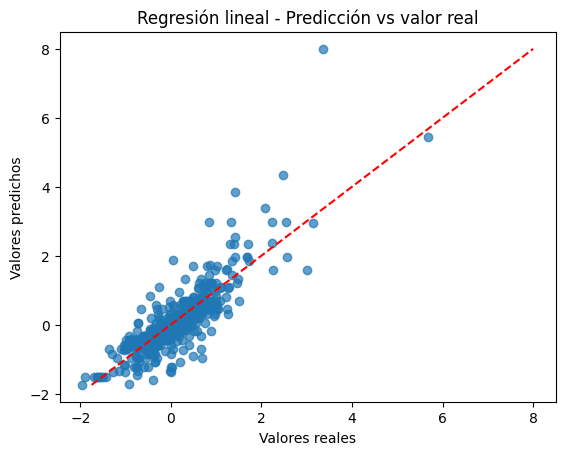

In [16]:
df = df.drop(columns=["fecha_extraccion"])
#Reasignaremos valores de la variable categórica de "encuadernación" con menor frecuencia que 10, ya que serían muy pocos para considerar en un modelo.
frecuencias = df["encuadernacion"].value_counts()
df["encuadernacion"] = np.where(df["encuadernacion"].map(frecuencias) >= 10, df["encuadernacion"], "otro")

#Reasignaremos valores de la variable categórica de "editorial" con menor frecuencia que 10, ya que serían muy pocos para considerar en un modelo.
frecuencias = df["editorial"].value_counts()
df["editorial"] = np.where(df["editorial"].map(frecuencias) >= 10, df["editorial"], "otro")

#Reasignaremos valores de la variable categórica de "encuadernación" con menor frecuencia que 10, ya que serían muy pocos para considerar en un modelo.
frecuencias = df["macrocategoria"].value_counts()
df["macrocategoria"] = np.where(df["macrocategoria"].map(frecuencias) >= 10, df["macrocategoria"], "otro")

#Creamos una variable categórica que indica los rangos de descuento. Será utilizada como variable objetivo para uno de los modelos.
bins = [-float("inf"), 0.19, 0.24, 0.29, float("inf")]
labels = ["<0.2", "0.20-0.24", "0.25-0.29", "0.3 o más"]
df["rango_descuento"] = pd.cut(df["porcentaje_descuento"], bins=bins, labels=labels)


#Nos deshacemos de las variables que no serán consideradas para un modelo.
df = df.drop(columns=["titulo","categoria", "autor", "descripcion", "link", "precio_oferta","porcentaje_descuento","rango_descuento","largo","ancho","grosor","disponibles"])
#Separamos e identificamos variables numéricas y categóricas
variables_numericas = df.select_dtypes(include="number").columns.tolist()
variables_categoricas = df.select_dtypes(include=["object","category"]).columns.tolist()
df[variables_numericas].corr()


#Estandarizamos las variables numéricas
df = estandarizar(df)
#realizamos one-hot encoding en las variables categóricas
df = pd.get_dummies(df, columns=variables_categoricas, drop_first=True)
df = df.astype(float)


#Separamos la variable objetivo y los conjuntos de entrenamiento
X = df.drop("precio_original", axis=1)
y = df["precio_original"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


#Modelo con sklearn

#Creamos y ajustamos el modelo
#modelo = LinearRegression()
#modelo.fit(X_train, y_train)

#Realizamos las predicciones
y_pred_train = modelo_cargado.predict(X_train)
y_pred_test = modelo_cargado.predict(X_test)

# Métricas de error y bondad de ajuste tanto del entrenamiento como predicción.
print("Entrenamiento:")
print("R²:", r2_score(y_train, y_pred_train))
print("MSE:", mean_squared_error(y_train, y_pred_train))
print("RMSE:",  np.sqrt(mean_squared_error(y_train, y_pred_train)))
print("\nPrueba:")
print("R²:", r2_score(y_test, y_pred_test))
print("MSE:", mean_squared_error(y_test, y_pred_test))
print("RMSE:",  np.sqrt(mean_squared_error(y_test, y_pred_test)))
#Gráfica comparativa de predicción vs valor real
plt.scatter(y_pred_test, y_test, alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], "r--")
plt.xlabel("Valores reales")
plt.ylabel("Valores predichos")
plt.title("Regresión lineal - Predicción vs valor real")
plt.show()